In [10]:
import sys
import os
pathToCsaranshPP = "/home/utkarsh/code/AnuVikar/" # change if required
sys.path.append(pathToCsaranshPP)
from pysrc.anuvikar_cdb_helper import getDefaultConfig, getDefaultInfos, processXyzFilesInDirGivenInfo, processXyzFileGivenInfo
buildDir = os.path.join(pathToCsaranshPP, "_build")
libPath = os.path.join(buildDir, "libanuvikar_shared.so")  # path to anuvikar library
if (not os.path.exists(buildDir) or not os.path.exists(libPath)):
    print("Library not found. Might be due to build errors in cmake.")
    print("If built successfully, specify correct build directory & lib file (so / dlib / dlib) above.")
    
import plotly as py
import plotly.express as px
import json
cascades = None
debug = False
data = None

def isInterstitial(coord):
    return 1 == coord[3]

def isSurviving(coord):
    return 1 == coord[5]

In [2]:
import ipyparallel as ipp

In [3]:
npp = 4
!ipcluster start -n {npp} --daemonize

2023-06-19 15:57:49.978 [IPClusterStart] Starting ipcluster with [daemonize=True]
2023-06-19 15:57:50.493 [IPController] Hub listening on tcp://127.0.0.1:49717 for registration.
2023-06-19 15:57:50.496 [IPController] Hub using DB backend: DictDB
2023-06-19 15:57:50.748 [IPController] hub::created hub
2023-06-19 15:57:50.749 [IPController] writing connection info to /home/utkarsh/.ipython/profile_default/security/ipcontroller-client.json
2023-06-19 15:57:50.750 [IPController] writing connection info to /home/utkarsh/.ipython/profile_default/security/ipcontroller-engine.json
2023-06-19 15:57:50.751 [IPController] task::using Python leastload Task scheduler
2023-06-19 15:57:50.763 [IPController] Heartmonitor beating every 3000ms
2023-06-19 15:57:50.765 [task] Task scheduler started [leastload]
2023-06-19 15:57:50.765 [broadcast-00] BroadcastScheduler 00 started
2023-06-19 15:57:50.765 [broadcast-0] BroadcastScheduler 0 started
2023-06-19 15:57:50.766 [broadcast-01] BroadcastScheduler 01 s

In [4]:
client = ipp.Client()

In [6]:
# wait and rerun after a few seconds if it shows error
view = client[:]

In [12]:
from pysrc.anuvikar_cdb_helper import ippProcessXyzFilesInDirGivenInfo

In [8]:
view.map_sync(os.chdir, [pathToCsaranshPP]*npp)
print(view.apply_sync(os.getcwd))

['/home/utkarsh/code/AnuVikar', '/home/utkarsh/code/AnuVikar', '/home/utkarsh/code/AnuVikar', '/home/utkarsh/code/AnuVikar']


In [13]:
if not cascades:
    config = getDefaultConfig()
    config['logFilePath'] = "local-log.txt"
    config['anuvikarLib'] = libPath
    info, extraInfo = getDefaultInfos()
    extraInfo['substrate'] = "Fe"
    extraInfo['isPKAGiven'] = False
    info['structure'] = "bcc"
    info['isIgnoreBoundary'] = False
    info['xyzFileType'] = "Generic"
    info['xyzColumnStart'] = 2
    info["latticeConst"] = 2.86
    #info["latticeConst"] = 3.18#652
    extraInfo['energy'] = 20
    #info['originType'] = 1
    info['extraColumnStart'] = -2
    extraInfo["author"] = "Andrea"

    #xyzDir = "../T300K_50keV_data/"
    xyzDir = "/home/utkarsh/code/aviml/parallelize/006-fpos-20/"
    #xyzDir = "/media/utkarsh/data/andreas/3-Derlet-Dudarev/fpos"
    cascades = ippProcessXyzFilesInDirGivenInfo(xyzDir, info, extraInfo, config, view, prefix=[], suffix=["z"], outputJsonFilename="out.json")
#name="_mason_3_0"
#cascade['xyzFilePath'] = "./CRAMD_3.000_0.000.xyz"
#cascade['origin'] = [-3.7, 0, 0.0]
#cascade['boxSize'] = [638, 202.5, 202.5]

10 xyz files
Writing results to  out.json


In [14]:
!ipcluster stop 

2023-06-19 15:58:36.033 [IPClusterStop] Stopping cluster 
2023-06-19 15:58:36.034 [IPClusterStop] Stopping controller
2023-06-19 15:58:36.112 [IPClusterStop] Stopping engine(s): 1687170471


In [16]:
from pysrc.anuvikar_ml import validateForCdb

In [21]:
cascades = validateForCdb(cascades, isInit=True, isAddClusterComparison=False, isAddClassification=True)

Adding coordinates in eigen dimensions and convex hulls for cascades...
to /home/utkarsh/code/aviml/parallelize/006-fpos-20/006-fpos-20-1.xyz           finished.
Defect morphology identification & classification...
finished.


In [22]:
with open("cascades.json", 'w') as f:
    json.dump(cascades, f)

In [23]:
import seaborn as sns
import pandas as pd

<Axes: xlabel='id', ylabel='n_defects'>

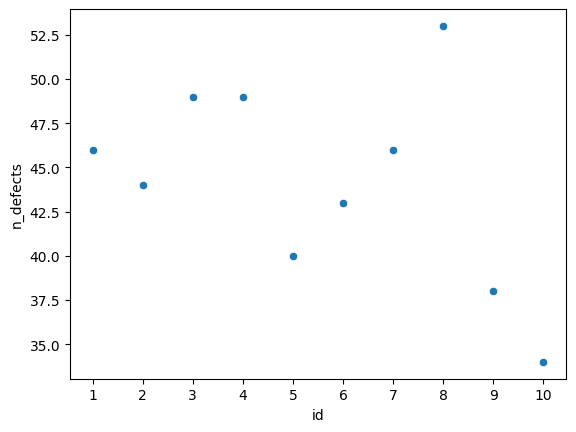

In [24]:
df = pd.DataFrame(cascades)
sns.scatterplot(data=df, x="id", y="n_defects")